## Importación de librerías

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Para la barra de progreso

In [ ]:
# 📂 Rutas
INPUT_FOLDER = "./outfits_originales_1024_rgba/"
OUTPUT_FOLDER_4c = "./outfits_procesados_1024_rgba/"
OUTPUT_FOLDER_3c = "./outfits_procesados_1024_rgb/"

# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_FOLDER_4c, exist_ok=True)
os.makedirs(OUTPUT_FOLDER_3c, exist_ok=True)

# 📑 Lista de imágenes originales
image_files = [f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"🔍 Encontradas {len(image_files)} imágenes en '{INPUT_FOLDER}'")

🔍 Encontradas 1525 imágenes en './outfits_originales_1024_rgba/'


## Código para una sola imagen

Forma de la imagen cargada (BGRA): (1024, 1024, 4)


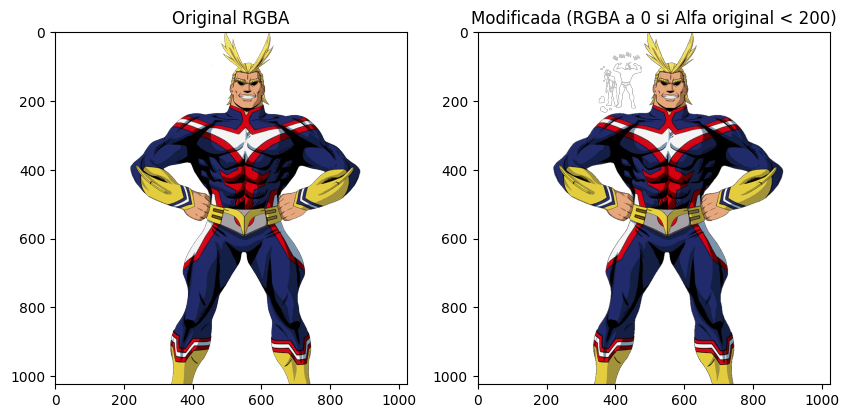

In [3]:
# --- Código para preprocesar la imagen limpiando los fondos ---

# 1. Cargar la imagen manteniendo todos los canales (incluido el alfa)
input_file_path = os.path.join(INPUT_FOLDER, image_files[124])
image_bgra = cv2.imread(input_file_path, cv2.IMREAD_UNCHANGED)

if image_bgra is None:
    print(f"Error: No se pudo cargar la imagen en {input_file_path}")
else:
    print(f"Forma de la imagen cargada (BGRA): {image_bgra.shape}")

    # 2. Verificar que la imagen tenga 4 canales (esperamos BGRA)
    if len(image_bgra.shape) < 3 or image_bgra.shape[2] != 4:
        print("Error: La imagen no tiene 4 canales (no es BGRA/RGBA).")
        print("Esta operación requiere una imagen con un canal alfa.")
    else:
        # Para trabajar más intuitivamente con RGBA (opcional, pero recomendado)
        # Convertimos de BGRA (OpenCV) a RGBA
        image_rgba = cv2.cvtColor(image_bgra, cv2.COLOR_BGRA2RGBA)

        # Crear una copia para no modificar la imagen original directamente
        processed_image_rgba = image_rgba.copy()

        # 3. Extraer el canal alfa (el cuarto canal, índice 3 en RGBA)
        alpha_channel_original = processed_image_rgba[:, :, 3]

        # 4. Crear máscaras para píxeles que se convertirán en fondo o objeto
        UMBRAL_OPACO = 200
        mask_to_clear = alpha_channel_original < UMBRAL_OPACO
        mask_is_object = alpha_channel_original >= UMBRAL_OPACO

        # 5. Para los píxeles identificados por la máscara [mask_to_clear],
        # establecer TODOS los canales (R, G, B, A) a 0.
        # La indexación [mask_to_clear] selecciona las filas (píxeles)
        # donde mask_to_clear es True.
        processed_image_rgba[mask_to_clear] = [0, 0, 0, 0] # R=0, G=0, B=0, A=0
        # Y para los que NO se modifican (los que son >= UMBRAL_OPACO), forzar su alfa a 255
        processed_image_rgba[mask_is_object, 3] = 255 # Forzar alfa a 255 para el objeto
        # Ahora 'processed_image_rgba' tiene los objetos de interés con alfa=255 y el resto con alfa=0


        # Mostrar la imagen modificada (usando Matplotlib para RGBA)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image_rgba, cmap='gray')
        axes[0].set_title("Original RGBA")
        axes[1].imshow(processed_image_rgba, cmap='gray')
        axes[1].set_title("Modificada (RGBA a 0 si Alfa original < 200)")
        plt.show()

Se encontraron 26 objetos. El más grande tiene un área de: 281142.5
Se ha aislado el objeto más grande.


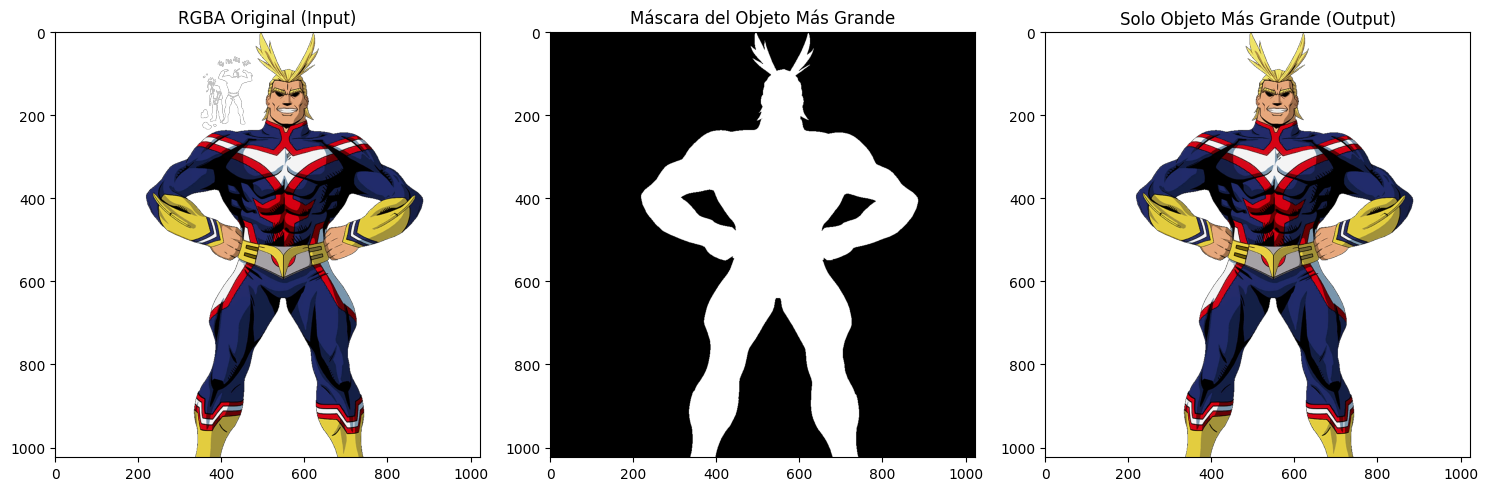

Imagen final con solo el objeto más grande guardada en: ./outfits_procesados_1024_rgba/Character_EmeraldGlassTransform_1024_4c.png


In [4]:
# --- Código para encontrar el objeto más grande ---

# 1. Obtener una máscara binaria del canal alfa
# Nos aseguramos de que la máscara del canal alpha de la imagen procesada es uint8
alpha_for_contours = processed_image_rgba[:, :, 3].astype(np.uint8)

# 2. Encontrar contornos en la máscara binaria
# cv2.RETR_EXTERNAL recupera solo los contornos exteriores extremos.
# cv2.CHAIN_APPROX_SIMPLE comprime segmentos horizontales, verticales y diagonales,
# dejando solo sus puntos finales.
contours, hierarchy = cv2.findContours(alpha_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. Calcular áreas y encontrar el contorno más grande
largest_contour = None
max_area = 0
if contours: # Verificar si se encontró algún contorno
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour
    print(f"Se encontraron {len(contours)} objetos. El más grande tiene un área de: {max_area}")
else:
    print("No se encontraron objetos (contornos) en la imagen.")

# 4. Crear una nueva imagen RGBA completamente transparente ([0,0,0,0])
# Usaremos la forma de la imagen original.
final_image_rgba = np.zeros_like(processed_image_rgba)

# 5. Si se encontró un objeto más grande, dibujar solo ese en la imagen final
if largest_contour is not None and max_area > 0:
    # Crear una máscara temporal solo para el objeto más grande
    silhouette_mask  = np.zeros_like(alpha_for_contours, dtype=np.uint8)
    cv2.drawContours(silhouette_mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)
    # Usar esta máscara para copiar los píxeles del objeto más grande
    # desde la imagen original (processed_image_rgba) a la final_image_rgba.
    # Esto preserva los colores originales del objeto más grande.
    # `np.where` o indexación booleana es eficiente aquí.
    # Donde temp_mask es 255 (blanco), copiamos el píxel de processed_image_rgba.
    # Donde temp_mask es 0 (negro), final_image_rgba permanece [0,0,0,0].
    final_image_rgba[silhouette_mask == 255] = processed_image_rgba[silhouette_mask == 255]
    print("Se ha aislado el objeto más grande.")
else:
    print("No se aisló ningún objeto (o no se encontró ninguno). La imagen de salida estará vacía.")


# 6. Mostrar resultados
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(processed_image_rgba, cmap="gray")
plt.title("RGBA Original (Input)")

plt.subplot(132)
# Para visualizar la máscara del objeto más grande (si se encontró)
if largest_contour is not None:
    display_mask = np.zeros_like(silhouette_mask, dtype=np.uint8)
    cv2.drawContours(display_mask, [largest_contour], -1, 255, cv2.FILLED)
    display_mask[processed_image_rgba[:,:,3] == 0] = 0
    plt.imshow(display_mask, cmap='gray')
    plt.title("Máscara del Objeto Más Grande")
else:
    plt.imshow(np.zeros_like(alpha_channel_original), cmap='gray') # Muestra negro si no hay objeto
    plt.title("Sin Objeto Más Grande")

plt.subplot(133)
plt.imshow(final_image_rgba, cmap="gray")
plt.title("Solo Objeto Más Grande (Output)")

plt.tight_layout()
plt.show()

# 7. Convertir la imagen final a BGRA para guardar con OpenCV
# (cv2.imwrite espera BGR o BGRA por defecto para PNGs con alfa)
final_image_bgra = cv2.cvtColor(final_image_rgba, cv2.COLOR_RGBA2BGRA)

# 7. Guardar la imagen final
output_file_path_4c = os.path.join(OUTPUT_FOLDER_4c, image_files[124])
output_file_path_4c = output_file_path_4c.replace('.png', '_1024_4c.png')
if cv2.imwrite(output_file_path_4c, final_image_bgra):
    print(f"Imagen final con solo el objeto más grande guardada en: {output_file_path_4c}")
else:
    print(f"Error al guardar la imagen final en: {output_file_path_4c}")

In [5]:
final_image_bgra[400,390]

array([0, 0, 0, 0], dtype=uint8)

In [7]:
# Descartamos el 4º canal alpha
final_image_rgb = final_image_rgba[:,:,:3]

# Convertir la imagen final a BGRA para guardar con OpenCV
# (cv2.imwrite espera BGR o BGRA por defecto para PNGs con alfa)
final_image_bgr = cv2.cvtColor(final_image_rgb, cv2.COLOR_RGB2BGR)

# Guardar la imagen final sin el canal alfa
output_file_path_3c = os.path.join(OUTPUT_FOLDER_3c, image_files[124])
output_file_path_3c = output_file_path_3c.replace('.png', '_1024_3c.png')
if cv2.imwrite(output_file_path_3c, final_image_bgr):
    print(f"Imagen final con solo el objeto más grande guardada en: {output_file_path_3c}")
else:
    print(f"Error al guardar la imagen final en: {output_file_path_3c}")

Imagen final con solo el objeto más grande guardada en: ./outfits_procesados_1024_rgb/Character_EmeraldGlassTransform_1024_3c.png


In [7]:
final_image_bgr[400,390]

array([0, 0, 0], dtype=uint8)

## Código para todas las imágenes del dataset

In [ ]:
# Lista de imágenes originales
try:
    image_files = [f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f"⚠️ No se encontraron imágenes en '{INPUT_FOLDER}'. Verifica la ruta y los archivos.")
        exit()
    print(f"🔍 Encontradas {len(image_files)} imágenes en '{INPUT_FOLDER}' para procesar.")
except FileNotFoundError:
    print(f"❌ Error: La carpeta de entrada '{INPUT_FOLDER}' no fue encontrada.")
    exit()


# Procesar cada imagen
imagenes_procesadas = 0
for image_file in tqdm(image_files, desc="Procesando imágenes"):

    # === PASO 1: Cargar y Preprocesar la Imagen (Limpiar Fondos) ===

    # 1.1 Cargar la imagen manteniendo todos los canales (incluido el alfa)
    input_path = os.path.join(INPUT_FOLDER, image_file)
    image_bgra = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

    if image_bgra is None:
        tqdm.write(f"Error: No se pudo cargar la imagen en {input_path}")
        continue # Saltar a la siguiente imagen

    # 1.2 Verificar que la imagen tenga 4 canales (esperamos BGRA)
    if len(image_bgra.shape) < 3 or image_bgra.shape[2] != 4:
        tqdm.write(f"Error: La imagen {image_file} no tiene 4 canales. Se omitirá.")
        continue

    # 1.3 Convertir de BGRA (OpenCV) a RGBA para trabajo interno más intuitivo
    image_rgba = cv2.cvtColor(image_bgra, cv2.COLOR_BGRA2RGBA)
    processed_image_rgba = image_rgba.copy() # Trabajar sobre una copia

    # 1.4 Extraer el canal alfa y crear máscara para píxeles no completamente opacos
    alpha_channel_original = processed_image_rgba[:, :, 3]

    # 1.5. Crear máscaras para píxeles que se convertirán en fondo o objeto
    UMBRAL_OPACO = 200
    mask_to_clear = alpha_channel_original < UMBRAL_OPACO
    mask_is_object = alpha_channel_original >= UMBRAL_OPACO

    # 1.6 Establecer píxeles no opacos a [0, 0, 0, 0]
    processed_image_rgba[mask_to_clear] = [0, 0, 0, 0]
    # Y para los que NO se modifican (los que son >= UMBRAL_OPACO), forzar su alfa a 255
    processed_image_rgba[mask_is_object, 3] = 255 # Forzar alfa a 255 para el objeto
    # Ahora 'processed_image_rgba' tiene los objetos de interés con alfa=255 y el resto con alfa=0

    # === PASO 2: Aislar el Objeto Más Grande ===

    # 2.1. Obtener una máscara binaria del canal alfa
    # Nos aseguramos de que la máscara del canal alpha de la imagen procesada es uint8
    alpha_for_contours = processed_image_rgba[:, :, 3].astype(np.uint8)

    # 2.2 Encontrar contornos
    contours, _ = cv2.findContours(alpha_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 2.3 Calcular áreas y encontrar el contorno más grande
    largest_contour = None
    max_area = 0
    if contours:
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                largest_contour = contour
    else:
        tqdm.write(f"Info: No se encontraron contornos en {image_file} después del preprocesamiento.")
        # No es un error grave, simplemente no habrá objeto largest_contour.

    # 2.4 Crear una nueva imagen RGBA completamente transparente ([0,0,0,0])
    final_image_rgba = np.zeros_like(processed_image_rgba)

    # 2.5 Si se encontró un objeto más grande, dibujarlo en la imagen final
    if largest_contour is not None and max_area > 0:
        # Crear una máscara temporal solo para el objeto más grande
        silhouette_mask = np.zeros_like(alpha_for_contours, dtype=np.uint8)
        cv2.drawContours(silhouette_mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)

        # Usar esta máscara para copiar los píxeles del objeto más grande
        # desde 'processed_image_rgba' (que tiene los colores correctos del objeto)
        # a 'final_image_rgba'.
        final_image_rgba[silhouette_mask == 255] = processed_image_rgba[silhouette_mask == 255]
    else:
        tqdm.write(f"Info: No se aisló ningún objeto en {image_file}. La imagen de salida estará vacía.")
        tqdm.write("No se procesa esta imagen.")
        continue

    # === PASO 3: Guardar la Imagen Resultante en 3 y 4 canales ===

    # 3.1 Convertir la imagen final (que está en RGBA) de nuevo a BGRA para guardar con OpenCV
    final_image_bgra = cv2.cvtColor(final_image_rgba, cv2.COLOR_RGBA2BGRA)

    # 3.2 Guardar la imagen final en 4c
    output_file_path_4c = os.path.join(OUTPUT_FOLDER_4c, image_file)
    output_file_path_4c = output_file_path_4c.replace('.png', '_1024_4c.png')
    if not cv2.imwrite(output_file_path_4c, final_image_bgra):
        tqdm.write(f"Error al guardar la imagen procesada en 4c: {output_file_path_4c}")
        continue
    
    imagenes_procesadas += 1

print(f"\n✅ Procesamiento completado. {imagenes_procesadas} imágenes procesadas.")
print(f"Las imágenes resultantes se encuentran en: '{OUTPUT_FOLDER_4c}'")

🔍 Encontradas 1525 imágenes en './outfits_originales_1024_rgba/' para procesar.


Procesando imágenes:   0%|          | 0/1525 [00:00<?, ?it/s]

Procesando imágenes: 100%|██████████| 1525/1525 [03:21<00:00,  7.57it/s]


✅ Procesamiento completado. 1525 imágenes procesadas.
Las imágenes resultantes se encuentran en: './outfits_procesados_1024_rgb/' y './outfits_procesados_1024_rgba/'


## Código para convertir imágenes de 4 canales RGBA a sólo 3 canales RGB

In [10]:
# 📑 Lista de imágenes a convertir a 3 canales
image_files = [f for f in os.listdir(OUTPUT_FOLDER_4c) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"🔍 Encontradas {len(image_files)} imágenes en '{OUTPUT_FOLDER_4c}'")

# Procesar cada imagen
imagenes_procesadas = 0
for image_file in tqdm(image_files, desc="Procesando imágenes"):

    # 1. Cargar la imagen manteniendo todos los canales (incluido el alfa)
    input_path = os.path.join(OUTPUT_FOLDER_4c, image_file)
    image_bgra = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

    if image_bgra is None:
        tqdm.write(f"Error: No se pudo cargar la imagen en {input_path}")
        continue # Saltar a la siguiente imagen

    # 2. Convertir la imagen final a BGRA para guardar con OpenCV
    # (cv2.imwrite espera BGR o BGRA por defecto para PNGs con alfa)
    final_image_bgr = cv2.cvtColor(image_bgra, cv2.COLOR_BGRA2BGR)

    # 3. Guardar la imagen final sin el canal alfa
    output_file_path_3c = os.path.join(OUTPUT_FOLDER_3c, image_file)
    output_file_path_3c = output_file_path_3c.replace('4c.png', '3c.png')
    if not cv2.imwrite(output_file_path_3c, final_image_bgr):
        tqdm.write(f"Error al guardar la imagen procesada en 3c: {output_file_path_3c}")
        continue
    
    imagenes_procesadas += 1

print(f"\n✅ Procesamiento completado. {imagenes_procesadas} imágenes procesadas.")
print(f"Las imágenes resultantes se encuentran en: '{OUTPUT_FOLDER_3c}'")

🔍 Encontradas 1485 imágenes en './outfits_procesados_1024_rgba/'


Procesando imágenes: 100%|██████████| 1485/1485 [04:34<00:00,  5.40it/s]


✅ Procesamiento completado. 1485 imágenes procesadas.
Las imágenes resultantes se encuentran en: './outfits_procesados_1024_rgb/'
